# First Steps: CAM
- resnet 50 has already the right structure with conv - GAP - dense
- otherwise we need to retrain the network with this structure
- for general application without retraining use gradCAM

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import zoom
input_path = "C:/DL_Lab/Racoon_dataset/train/"

(-0.5, 223.5, 223.5, -0.5)

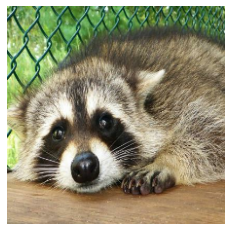

In [2]:
image = tf.io.read_file(input_path + "raccoon-20_jpg.rf.fb19aa368c074a61eed8829617ed6b7c.jpg")
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (224,224), method=tf.image.ResizeMethod.BILINEAR)
orig_image = image
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image/255)
plt.axis("off")



In [3]:
# pretrained model
resnet = ResNet50(input_shape=(224,224,3), include_top=True, weights="imagenet")
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [4]:
pred = resnet.predict(image)
pred_name = decode_predictions(pred, top=1)[0][0][1]
pred_index = np.argmax(pred[0])

In [5]:
# get model that ends with last conv layer
last_conv_layer = resnet.get_layer("conv5_block3_out")
model = Model(inputs=resnet.input, outputs=last_conv_layer.output)
fmaps = model.predict(image)[0]
fmaps.shape

(7, 7, 2048)

In [6]:
# get weights of last dense layer to weight the feature maps 
last_dense = resnet.get_layer("predictions")
fmap_weights = last_dense.get_weights()[0] # weights, [1] would be bias
fmap_weights.shape # 2048 feature maps and 1000 classes

(2048, 1000)

In [7]:
# 2048 weights (one per fmap) of winner class
class_fmap_weights = fmap_weights[:,pred_index]
# 7x7 cam image = w1 * f1 + w2 * f2 + ... weighted addition of fmaps
cam = fmaps.dot(class_fmap_weights)
cam.shape

(7, 7)

In [20]:
# upsample cam to original image size 224x224 (32 times)
ups_cam = zoom(cam, (32,32), order=1)
# scale cam to [0,1]
min = tf.math.reduce_min(ups_cam)
max = tf.math.reduce_max(ups_cam)
ups_cam = (ups_cam - min) / (max - min)

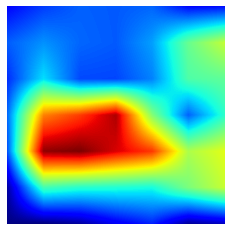

In [23]:
plt.imshow(ups_cam, cmap="jet")
plt.axis("off")
plt.savefig('cam.png', bbox_inches='tight')


(-0.5, 223.5, 223.5, -0.5)

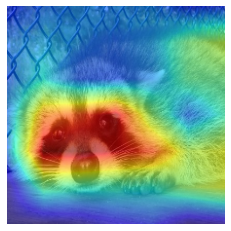

In [22]:
plt.imshow(orig_image/255, alpha=1)
plt.imshow(ups_cam, cmap="jet", alpha=0.6)
plt.axis("off")

In [9]:
map = np.ones((3,3,3))
print(map)
w = np.asarray([1,2,3])
np.dot(map,w)


[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


array([[6., 6., 6.],
       [6., 6., 6.],
       [6., 6., 6.]])